# Cargar el modelo

In [2]:
import numpy as np
from tensorflow.keras import models
import matplotlib.pyplot as plt

path_model = 'modelo_cnn_20240923025056.keras'

# Cargar los pesos en el modelo
model = models.load_model(path_model)

# Resumen del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,888,392 (114.02 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,200,454 (16.02 MB)

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

## Calcular una matriz de confusión

In [ ]:
# Parámetros
data_dir = 'data'
batch_size = 32
img_height = 128
img_width = 128

# Generador de validación
val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   # 20% validación
    subset="validation",    # Usar el conjunto de validación
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
).map(lambda x, y: (x / 255.0, y))  # Normalizar las imágenes

# Obtener las etiquetas verdaderas y las imágenes
true_labels = []
predictions = []

for images, labels in val_dataset:
    # Obtener las predicciones del modelo
    preds = model.predict(images, verbose=0)
    predictions.extend(np.argmax(preds, axis=1))  # Convertir las predicciones a clases
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convertir las etiquetas a clases

# Convertir a arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Calcular la matriz de confusión
cm = confusion_matrix(true_labels, predictions)

# Crear un DataFrame de pandas con la matriz de confusión
clases = ['Sinovio', 'Estroma', ]
df_cm = pd.DataFrame(cm, index=clases, columns=clases)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Clase predicha')
plt.ylabel('Clase real')
plt.title('Matriz de confusión')
plt.show()


## Cargar openslide 

In [3]:
import os

OPENSLIDE_PATH = r'C:\Users\achav\Documents\Osteoartritis\openslide-win64\bin'

if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
        print('Using OpenSlide from', openslide.__file__)
else:
    import openslide


Using OpenSlide from c:\Users\achav\Documents\Osteoartritis\venv\Lib\site-packages\openslide\__init__.py


## Cargar la imagen

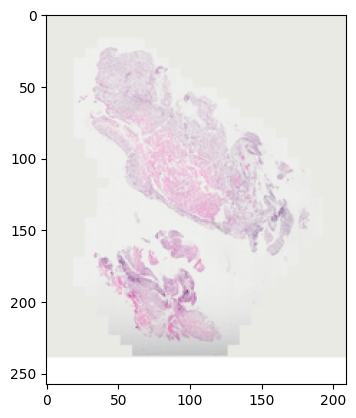

In [426]:
import os

# 8
plate_name = "MS-33-23_008"
filename = plate_name + ".svs"
dir_path = f"D:/"
file_path = f"{dir_path}/{filename}"

absolute_path = os.path.abspath(file_path)

# Check if file exists
if not os.path.isfile(file_path):
    print(f"File {file_path} not found")

slide = openslide.OpenSlide(file_path)

# Get a thumbnail of the whole slide
thumbnail = slide.get_thumbnail((slide.dimensions[0] // 256, slide.dimensions[1] // 256))

# Convert the thumbnail to a numpy array
thumbnail = np.array(thumbnail)

# Display the thumbnail
plt.imshow(thumbnail)

# Predecir y crear una nueva imagen con las predicciones

In [427]:
import cv2
from collections import defaultdict

class_colors = {0: (255, 0, 0), 1: (0, 0, 255), 2: (0, 255, 0)}
level = 0

# Get the dimensions of the slide
width, height = slide.level_dimensions[level]

print(slide.level_dimensions)
print(slide.level_downsamples)
print(width, height)

downsized_image = slide.get_thumbnail((slide.level_dimensions[level][0] // 512, slide.level_dimensions[level][1] // 512))
downsized_image = np.array(downsized_image)
results = np.zeros((slide.level_dimensions[level][1] // 512, slide.level_dimensions[level][0] // 512, 3), dtype=np.uint8)

predictions = []

print(downsized_image.shape, results.shape)

# Create a count dict to store the number of tiles for each class
count = defaultdict(int)

# print(results.shape)

total = width * height // (512 * 512)

for i in range(0, width, 512):    
    for j in range(0, height, 512):
        try:
            image = slide.read_region((i, j), level, (512, 512)).convert("RGB")
            # Show thumbnail
            image = image.resize((128, 128))

            image = np.array(image)

            # Calcular el promedio de los píxeles
            white_pixels = np.mean(image)

            # print(f"White pixels: {white_pixels.round(0)}")

            # Si la región es muy blanca, no hacer predicción
            if white_pixels > 230:
                # cv2.rectangle(results, (i // 512, j // 512), (i // 512 + 1, j // 512 + 1), (255, 255, 255), -1)
                continue

            # Normalizar la imagen
            image = image / 255.0
            
            # Añadir una dimensión para el batch
            image = np.expand_dims(image, axis=0)

            # Hacer predicción con el modelo
            prediction = model.predict(image, verbose=0)

            # Obtener la clase con la mayor probabilidad
            prediction = np.argmax(prediction)
            predictions.append((i, j, prediction))

            count[prediction] += 1

        except Exception as e:
            import winsound
            winsound.PlaySound("SystemExclamation", winsound.SND_ALIAS)
            print(f"Error: {e}")
    print(f"Processed {i >> 9} of {width >> 9} rows. Percentage: {i * 100 // width} %", end="\r")

print(count)

((53707, 66287), (13426, 16571), (3356, 4142), (1678, 2071))
(1.0, 4.000202243103928, 16.00344957523989, 32.00689915047978)
53707 66287
(128, 104, 3) (129, 104, 3)
defaultdict(<class 'int'>, {1: 2967, 0: 832})


In [428]:
downsize_scale = 16

class_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}

downsized_image = slide.get_thumbnail((slide.level_dimensions[level][0] // downsize_scale, slide.level_dimensions[level][1] // downsize_scale))
downsized_image = np.array(downsized_image)
results = np.ones((slide.level_dimensions[level][1] // downsize_scale, slide.level_dimensions[level][0] // downsize_scale, 3), dtype=np.uint8)*255

# Convertir a imagen RGB
downsized_image = cv2.cvtColor(downsized_image, cv2.COLOR_RGBA2RGB)
results = cv2.cvtColor(results, cv2.COLOR_RGBA2RGB)

print(downsized_image.shape, results.shape)

for i, j, prediction in predictions:
    # cv2.rectangle(downsized_image, (i // 512, j // 512), (i // 512 + 1, j // 512 + 1), class_colors[prediction], -1)
    cv2.rectangle(results, (i // downsize_scale, j // downsize_scale), (i // downsize_scale + 256 // downsize_scale, j // downsize_scale + 256 // downsize_scale), class_colors[prediction], 3)


cv2.imwrite(f"results/png/{plate_name}_predictions.png", cv2.cvtColor(downsized_image, cv2.COLOR_RGB2BGR))
cv2.imwrite(f"results/png/{plate_name}_results.png", cv2.cvtColor(results, cv2.COLOR_RGB2BGR))

## Tiff
import tifffile as tiff

tiff.imwrite(f"results/tiff/{plate_name}_predictions.tiff", downsized_image)
tiff.imwrite(f"results/tiff/{plate_name}_results.tiff", results)


(4142, 3356, 3) (4142, 3356, 3)


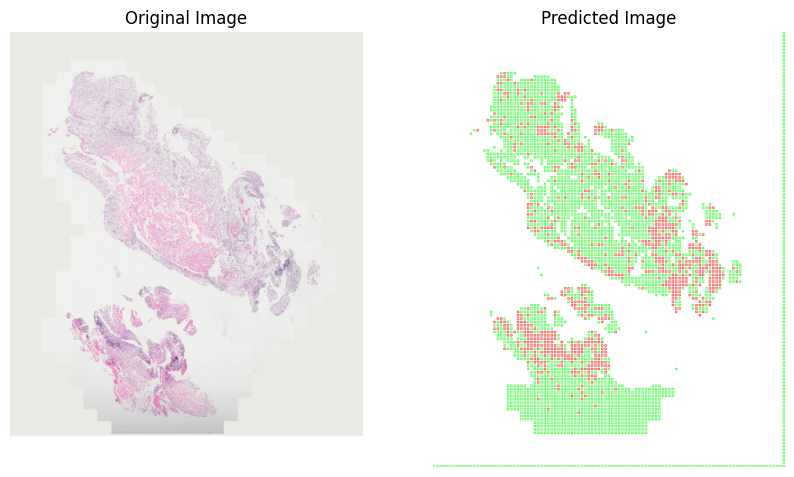

In [429]:
import winsound

# Compare original image with the predicted image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(downsized_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)

plt.imshow(results)
plt.title("Predicted Image")
plt.axis("off")

plt.show()

# Play a sound of success when the process is finished
winsound.PlaySound("SystemAsterisk", winsound.SND_ALIAS)

In [430]:
# Mostrar el porcentaje por clase
total = sum(count.values())
for key in count:
    count[key] = count[key] / total * 100

print(count)

with open(f"results/{plate_name}_results.txt", "w") as f:
    f.write(str(count))

defaultdict(<class 'int'>, {1: 78.09949986838642, 0: 21.900500131613583})
